# XPCS&XSVS Pipeline for Setup of (Gi)-SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Compress Data
* Define Q-ROI, e.g. qr for SAXS, (qr, qz) for gi-saxs

The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Load Packages

Import packages for I/O, visualization, and analysis.

In [3]:
from pyCHX.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *

from skimage.draw import line_aa, line, polygon, ellipse


In [4]:
%matplotlib notebook
#%matplotlib inline

# Define Scattering Geometry Here

In [66]:
scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_waxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
                           # gi_waxs define a simple box-shaped ROI 
qphi_analysis = False #True  #if True, do q-phi analysis in case of SAXS
force_compress = False 
single_image = True #take one image for make ROI

# Define Result Save Folder

In [7]:
CYCLE= '2018_2'  #change clycle here
#username = 'commissioning'
username =  getpass.getuser()
username = 'trosen'

path = '/XF11ID/analysis/%s/masks/'%CYCLE
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )


Results from this analysis will be stashed in the directory /XF11ID/analysis/2018_2/trosen/Results/
/XF11ID/analysis/2018_2/trosen/Results/


## Load Metadata & Image Data

In [26]:
 uid = 'd3fff15d' #(scan num: 18444) (Measurement: Single image for masking )
    
    

In [27]:
#get_last_uids( -6 )

In [28]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2018_2/trosen/Results/d3fff15d/


In [29]:
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

filepath : /nsls2/xf11id1/data/2018/06/15/adeb309e-4e1b-4cc1-85c2
got images_per_file
scan_id, full-uid, data path are:  18444--d3fff15d-4081-474a-ba99-746e3943afff--/nsls2/xf11id1/data/2018/06/15/adeb309e-4e1b-4cc1-85c2_2145_master.h5


In [30]:
md = get_meta_data( uid )
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

md['acquire period' ] = md['cam_acquire_period']
md['exposure time'] =  md['cam_acquire_time']

More than one device. This would have unintented consequences.Currently, only use the first device.
The data are: Pipeline processed through proc_func. Original repr:
    EigerImages processed through proc_func. Original repr:
        <Frames>
        Length: 1 frames
        Frame Shape: 2167 x 2070
        Pixel Datatype: uint32


In [31]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> d3fff15d
number of images--> 1
uid--> d3fff15d-4081-474a-ba99-746e3943afff
scan_id--> 18444
start_time--> 2018-06-15 16:15:04
stop_time--> 2018-06-15 16:15:07
sample--> CoralPor
Measurement--> Single image for masking
acquire period--> 1.0000029802322388
exposure time--> 0.1
det_distance--> 4.9583471150000005
beam_center_x--> 1166.0
beam_center_y--> 1206.0


<IPython.core.display.Javascript object>


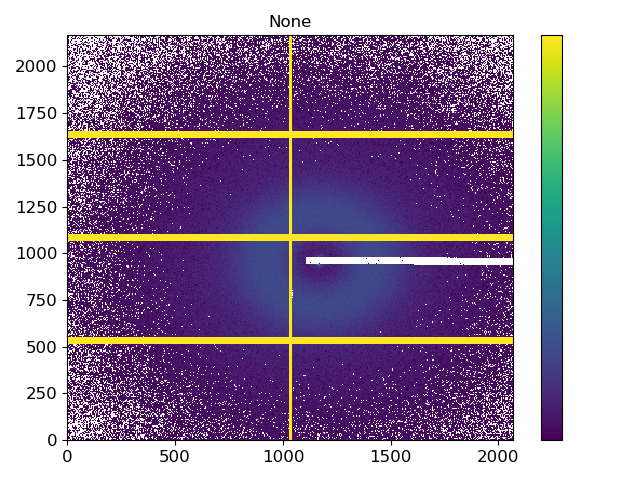

In [32]:
show_img( imgs[0],logs=True)

### Define incident beam center (also define reflection beam center for gisaxs)

In [33]:
if scat_geometry =='gi_saxs':
    inc_x0 =  md['beam_center_x'] 
    inc_y0 =  imgs[0].shape[0] - md['beam_center_y'] 
    
    refl_x0 =     951     #md['beam_center_x']  
    refl_y0 =     imgs[0].shape[0] -  1050     #imgs[0].shape[0] -  1758   
    
    print( "inc_x0, inc_y0, ref_x0,ref_y0 are: %s %s %s %s."%(inc_x0, inc_y0, refl_x0, refl_y0) )
else:
    inc_x0 =  imgs[0].shape[0] - md['beam_center_y']   
    inc_y0=   md['beam_center_x']
    ###for this particular uid, manually give x0/y0
    #inc_x0 = 1041
    #inc_y0 = 1085

In [40]:
dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )
if scat_geometry =='gi_saxs':center=center[::-1]
setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)
print_dict( setup_pargs )


The metadata: beam_center_x has been changed to 1166.0.
The metadata: beam_center_y has been changed to 961.0.
uid--> uid=d3fff15d
dpix--> 0.07500000356230885
Ldet--> 4958.3471150000005
lambda_--> 0.9686265
exposuretime--> 0.1
timeperframe--> 1.000003
center--> [961, 1166]
path--> /XF11ID/analysis/2018_2/trosen/Results/d3fff15d/


# Load Mask file

In [41]:
scat_geometry

'saxs'

In [42]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2018_1/masks/'    
    mask_name =  'April12_2018_4M_SAXS.npy' 
    
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2018_2/masks/'    
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
        mask_name = 'June15_2018_4M_SAXS.npy'   
        
    elif md['detector'] =='eiger500K_single_image':    
        mask_name = 'April16_2018_500K_SAXS.npy'         
elif scat_geometry == 'gi_waxs':
    mask_path = '/XF11ID/analysis/2018_2/masks/'    
    mask_name =  'June11_2018_1M_WAXS.npy'         
        

In [43]:
if md['detector'] =='eiger1m_single_image':
    Chip_Mask=np.load( '/XF11ID/analysis/2017_1/masks/Eiger1M_Chip_Mask.npy')
elif md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    Chip_Mask= np.array(np.load( '/XF11ID/analysis/2017_1/masks/Eiger4M_chip_mask.npy'), dtype=bool)
    BadPix =     np.load('/XF11ID/analysis/2018_1/BadPix_4M.npy'  )  
    Chip_Mask.ravel()[BadPix] = 0
elif md['detector'] =='eiger500K_single_image':
    Chip_Mask= 1  #to be defined the chip mask
else:
    Chip_Mask = 1
#show_img(Chip_Mask)

<IPython.core.display.Javascript object>


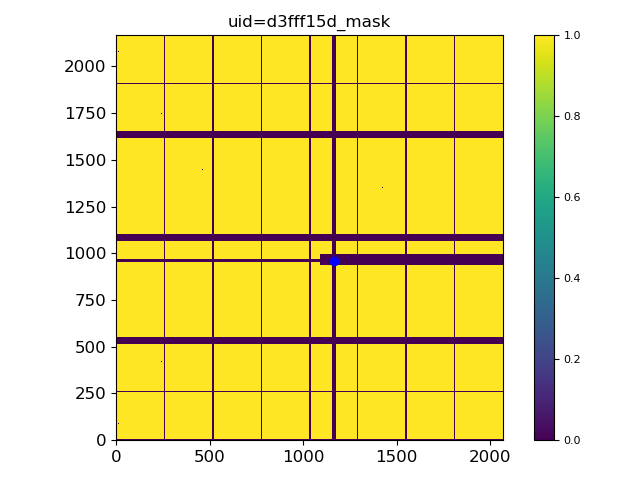

In [44]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= True ) 
mask =  mask * pixel_mask * Chip_Mask
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1, center=center[::-1])
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

In [45]:
#%run /home/yuzhang/chxanalys_link/chxanalys/chx_generic_functions.py

<IPython.core.display.Javascript object>


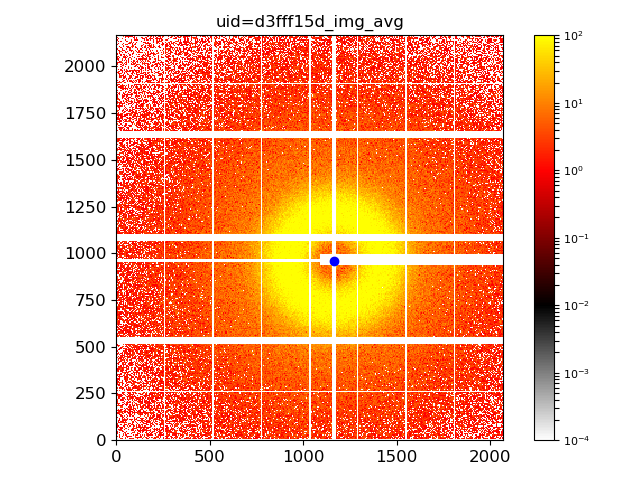

In [48]:
show_img( imgsa[0] ,  vmin=.0001, vmax= 1e2, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula, center=center[::-1] )

# Compress Data

In [49]:
good_start =0 #Usually we discard the first 5 files. The good_start could, however be 0 (no files discarded)

In [50]:
bin_frame = False #True # False # True  #generally make bin_frame as False
if bin_frame:
    bin_frame_number= 4
    timeperframe = acquisition_period * bin_frame_number
else:
    bin_frame_number =1

In [51]:
#single_image=False

In [52]:
if not single_image:
    force_compress=0
    import time
    t0= time.time()
    if bin_frame_number==1:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
    else:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number) 
    mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
             force_compress= force_compress,  para_compress= True,  bad_pixel_threshold = 1e14,
                            bins=bin_frame_number, num_sub= 100, num_max_para_process= 500, with_pickle=True  )
    min_inten = 10    
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
    print ('The good_start frame number is: %s '%good_start)
    FD = Multifile(filename, good_start, len(imgs)//bin_frame_number)
    #FD = Multifile(filename, good_start, 100)
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )
    plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
           title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
    Nimg = Nimg/bin_frame_number
    run_time(t0)
else:
    avg_img = imgsa[0]

mask =  mask * pixel_mask * Chip_Mask
mask_copy = mask.copy()


# Show the average image

<IPython.core.display.Javascript object>


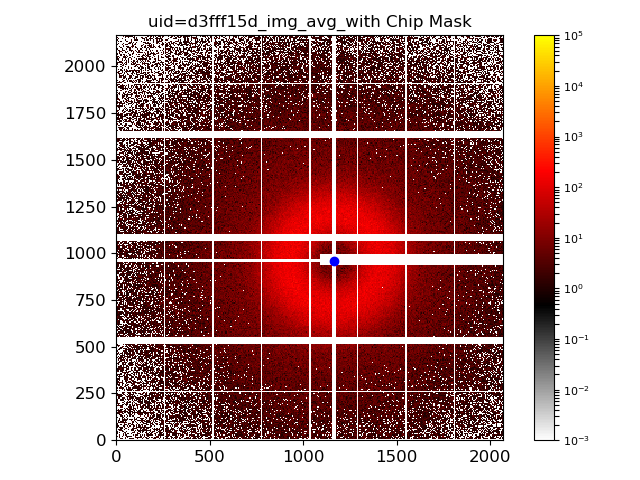

In [53]:
show_img( avg_img * Chip_Mask ,  vmin=1e-3, vmax= 1e5, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg_with Chip Mask',  save=True, path=data_dir, center=center[::-1], cmap = cmap_albula )

# Define ROI Depending on Scattering Geometry

## SAXS Scattering Geometry

In [55]:
setup_pargs 

{'uid': 'uid=d3fff15d',
 'dpix': 0.07500000356230885,
 'Ldet': 4958.3471150000005,
 'lambda_': 0.9686265,
 'exposuretime': 0.1,
 'timeperframe': 1.000003,
 'center': [961, 1166],
 'path': '/XF11ID/analysis/2018_2/trosen/Results/d3fff15d/'}

In [56]:
#np.where(hmask.ravel()==0)

<IPython.core.display.Javascript object>


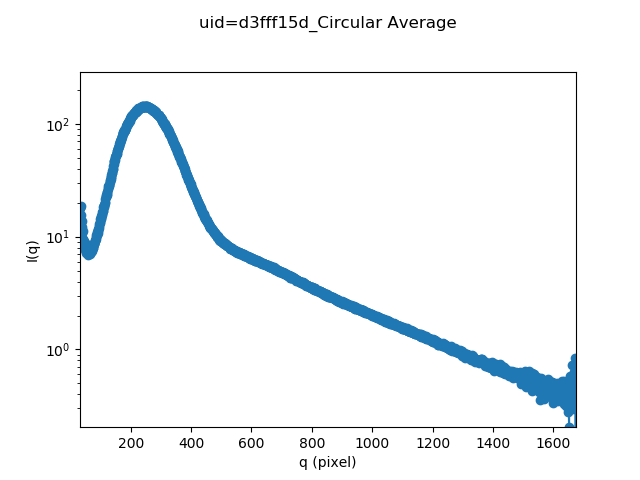

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


In [57]:
if scat_geometry =='saxs':
    mask = mask_copy.copy()
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 1e9, center=center, center_radius=10)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img*mask, mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, show_pixel=True,
                      xlim=[qp_saxs.min(), qp_saxs.max()*1.0], ylim = [iq_saxs.min(), iq_saxs.max()*2] )
    mask = np.array( mask * hmask, dtype=bool) 
    

<IPython.core.display.Javascript object>


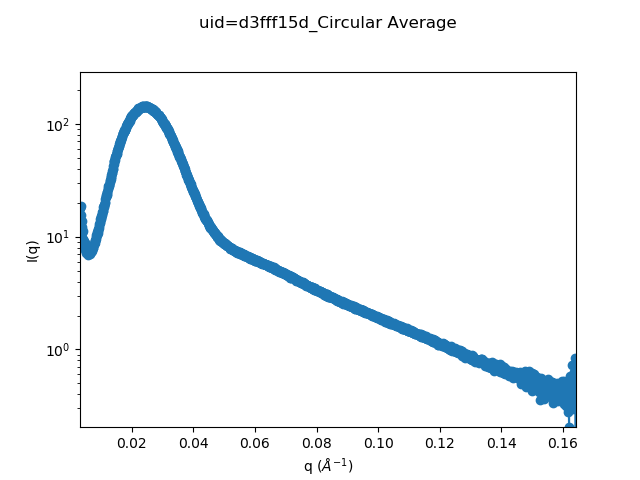

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


In [58]:
if scat_geometry =='saxs':   
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, show_pixel=False,
                      xlim=[q_saxs.min(), q_saxs.max()*1.0], ylim = [iq_saxs.min(), iq_saxs.max()*2] )
    

In [67]:
if scat_geometry =='saxs':    
    uniformq =  True #False    
    ## Define ROI
    #* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
    #* Create ring mask defined by  edges (all in pixel unit)    
    ### Define a non-uniform distributed rings by giving edges
    if not uniformq:
        
        qcenters =  [ 0.0029 ,  0.00708,  0.01126,  0.01544,  0.01963,  0.02381,
                    0.02799,  0.03217,  0.03636,  0.04054,  0.04472,  0.0489  ][:5] #in A-1        
        width = 0.0037 #0.00219 #0.0005  # in A-1     0.0037 for wide     0.00219 for slim

        #width =    np.array( [0.005,      0.005,  0.005,  0.005, 0.005, 0.005, ] ) * 1.4 
        
        edges = get_non_uniform_edges(  qcenters, width, number_rings =1 )    
        inner_radius= None
        outer_radius = None
        width = None
        num_rings = None        
    # Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)
    if uniformq:            
        inner_radius=   0.01  #0.0018
        outer_radius =   0.08 #0.05
        num_rings = 12 #18
        gap_ring_number = 20 #20 #1
        width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
        edges = None
        

12


<IPython.core.display.Javascript object>


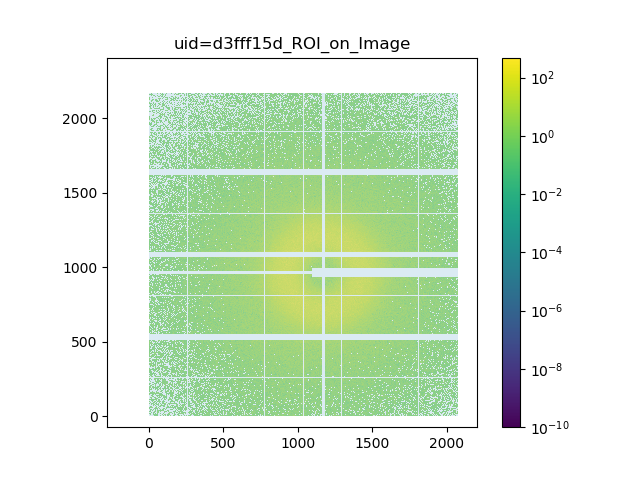

In [68]:
if scat_geometry =='saxs':
    roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
    qr = np.round( qr, 5)
    
    if md['detector'] =='eiger500K_single_image':
        qmax = 0.0285
        qr = qr[qr < qmax]
    
    print(len(qr))
    show_ROI_on_image( avg_img, roi_mask, center[::-1], label_on = False,
                rwidth = 1240, alpha=.4,  
                save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img),
                     aspect=1) 
    qval_dict = get_qval_dict( np.round(qr, 5)  ) 

In [69]:
#show_img( roi_mask,  vmin=-1, vmax= 12,   image_name= uidstr + '_roi_mask')

<IPython.core.display.Javascript object>


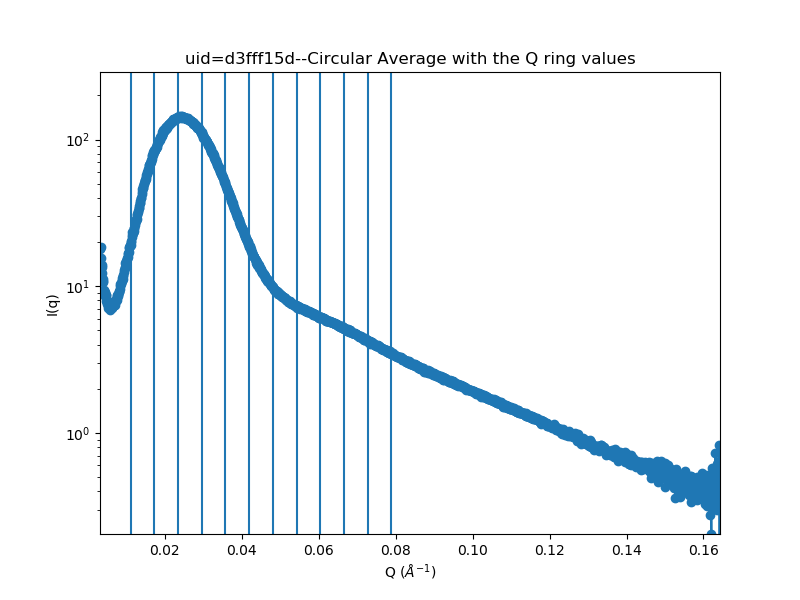

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


In [70]:
if scat_geometry =='saxs':
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, 
                      xlim= [q_saxs.min(), q_saxs.max()],
                  ylim = [iq_saxs.min(), iq_saxs.max()*2],  save=True, path=data_dir)

In [71]:
#qphi_analysis = False

In [72]:
if scat_geometry =='saxs':
    if qphi_analysis:     
        roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )    
        # define q-mask
        if False:#if True, redefine qcenters
            qcenters = [  0.0023,  0.00365, 0.0050, 0.00621, 0.00754, 0.00880  ] #in A-1        
            #width = 0.0001  # in A-1         
            #width =    [0.0001,      0.00012,  0.00014,  0.00016, 0.00018,  0.0002,  0.00022 ]
            width =    np.array( [0.0001,      0.00012,  0.00014,  0.00016, 0.00018,  0.0002,  0.00022 ] ) * 3.5

            edges = get_non_uniform_edges(  qcenters, width, number_rings=1 )    
            inner_radius= None
            outer_radius = None
            width = None
            num_rings = None         
            roi_mask_qr, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
                    outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                              unit='A',       pargs=setup_pargs   )
        else:#use the pre-defined qr mask
            roi_mask_qr  =  roi_mask 
        # define angle-mask        
        
        ang_centers = np.array( [  0, 10, 20,  30, 40, 50, 60, 70, 80,  90, 100,
                                   110, 120, 130, 140, 150, 160, 170, 180,  190, 200,
                                   210, 220,  230, 240, 250, 260, 270, 280,  290, 300,
                                  310, 320,  330, 340, 350,]) -180 #in degree
        ang_centers = np.array([0,90,180,270])-180
        
        ang_width =       np.array([  5, 5, 5,  5,  5,  5,  5, 5, 5,  5,  5,  5, 
                             5,  5,  5,  5,  5,  5, 5, 5,  5,  5,  5,   
                             5,  5,  5,  5,  5, 5, 5, 5,  5,  5,  5, 
                             5,  5,  5,  5, 5 ])*1.5 #in degree    
        
        ang_width = np.array([15,15,15,15]) *2/1.5
        
        ang_edges = get_non_uniform_edges(  ang_centers, ang_width, number_rings=1 )    
        inner_angle= None
        outer_angle = None
        ang_width = None    
        num_angles = None
        
        if False: #For Dhiraj's flow geometry
            inner_angle= 0
            outer_angle = 60
            ang_width = 5    
            num_angles = 10
            ang_edges = None
        
        roi_mask_ang, ang_center, ang_edge = get_angular_mask( mask,  inner_angle= inner_angle, 
                outer_angle = outer_angle, width = ang_width, edges = ang_edges,
                        num_angles = num_angles, center = center, flow_geometry= False ) 
        
        roi_mask, good_ind = combine_two_roi_mask( roi_mask_qr, roi_mask_ang,pixel_num_thres=100)   
        qval_dict_ = get_qval_dict(  qr_center = qr, qz_center = ang_center,one_qz_multi_qr=False)
        qval_dict = {  i:qval_dict_[k] for (i,k) in enumerate( good_ind) }
        
        show_ROI_on_image( avg_img, roi_mask, center, label_on = True, rwidth = 840, alpha=.9,  
                 save=True, path=data_dir, uid=uidstr, vmin= 1e-3,
                 vmax= 1e3, #np.max(avg_img),
                 aspect=1,
                 show_roi_edge=True,
                 show_ang_cor = True) 

# WAXS Geometry

In [64]:
def create_ellipse_donut(  cx, cy , wx_inner, wy_inner, wx_outer, wy_outer, roi_mask, gap=0):
    Nmax = np.max( np.unique( roi_mask ) )
    rr1, cc1 = ellipse( cy,cx,  wy_inner, wx_inner  )    
    rr2, cc2 = ellipse( cy, cx,  wy_inner + gap, wx_inner +gap ) 
    rr3, cc3 = ellipse( cy, cx,  wy_outer,wx_outer ) 
    roi_mask[rr3,cc3] = 2 + Nmax
    roi_mask[rr2,cc2] = 0
    roi_mask[rr1,cc1] = 1 + Nmax
    return roi_mask
def create_ellipse(  cx, cy , wx_inner, wy_inner, roi_mask):
    Nmax = np.max( np.unique( roi_mask ) )
    rr1, cc1 = ellipse( cy,cx,  wy_inner, wx_inner  ) 
    roi_mask[rr1,cc1] = 1 + Nmax
    return roi_mask
    
def create_box( cx, cy, wx, wy, roi_mask):
    Nmax = np.max( np.unique( roi_mask ) )
    for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
        x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
        y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
        rr, cc = polygon( y,x)         
        roi_mask[rr,cc] = i +1 + Nmax
    return roi_mask

def create_ellipse_donut_nonconcentric(cx_inner, cy_inner, cx_outer, cy_outer,
                                       wx_inner, wy_inner, wx_outer, wy_outer, roi_mask, gap=0):
    Nmax = np.max( np.unique( roi_mask ) )
    rr1, cc1 = ellipse(cy_inner, cx_inner,  wy_inner, wx_inner  )    
    rr2, cc2 = ellipse(cy_inner, cx_inner,  wy_inner + gap, wx_inner +gap ) 
    rr3, cc3 = ellipse(cy_outer, cx_outer,  wy_outer,wx_outer ) 
    roi_mask[rr3,cc3] = 2 + Nmax
    roi_mask[rr2,cc2] = 0
    roi_mask[rr1,cc1] = 1 + Nmax
    #np.set_printoptions(threshold=10)
    return roi_mask


In [73]:
if scat_geometry =='gi_waxs':
    box_roi = False
    single_box = False   #True, if True, the roi is one box, else, roi is multi-boxes
    ellipse_roi = True
    
    if box_roi:
        if not single_box:
            roi_mask = np.zeros_like( avg_img , dtype = np.int32)
            wx,wy = [20,10]  #each box width and height

            cx = np.int_(np.linspace( 55, 955, 10))  #box center-x        
            nx = len(cx)//2

            y1 = 760-8
            y2=  780-8
            cy1 = np.linspace( y1, y2, nx)
            cy2 = np.linspace( y2, y1, nx)


            cy = np.int_( np.concatenate( [cy1, cy2] ) )  #box-center y

            for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                rr, cc = polygon( y,x)
                #print( i + 1  )
                roi_mask[rr,cc] = i +1
            roi_mask = roi_mask * mask  
            
        else:

            roi_mask = np.zeros_like( avg_img , dtype = np.int32)
            wx,wy = [40,20]  #each box width and height    
            cx, cy = [[ 184, 817, 200, 800], [ 637, 637,200, 200]]     
            cx, cy = [[ 160, 817, 200, 800], [ 650, 637,200, 200]]    
            for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                rr, cc = polygon( y,x)
                #print( i + 1  )
                roi_mask[rr,cc] = i +1

            if False:
                Nmax = np.max( np.unique( roi_mask ) )
                print( Nmax)
                wx,wy = [30,10]  #each box width and height    
                cx, cy = [[ 44, 80], [ 725, 725]]     
                for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                    x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                    y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                    rr, cc = polygon( y,x)
                    #print( i + 1  )
                    roi_mask[rr,cc] = i +1 + Nmax
        
        
    if ellipse_roi ==True:
        #define donut shapes here
                
        roi_mask = np.zeros_like( avg_img , dtype = np.int32)
        #cx, cy = [ [422, 461], [345,345] ]
        #wx_inner, wy_inner = [10, 50]        
        #for i, [x,y] in enumerate(list(zip(cx,cy))):
            #roi_mask = create_ellipse(  x, y , wx_inner, wy_inner, roi_mask)
        cx_inner, cy_inner = [440,329]
        cx_outer, cy_outer = [440,329]
        wx_inner, wy_inner = [15,30]
        wx_outer, wy_outer = [100,150]
        roi_mask = create_ellipse_donut_nonconcentric(cx_inner, cy_inner, cx_outer, cy_outer,
                                                      wx_inner, wy_inner, wx_outer, wy_outer, roi_mask, gap=0)
    #define one box here
    #wx,wy = [40,15]  #each box width and height    
    #cx, cy = [[ 510], [ 880]]  
    #roi_mask = create_box( cx, cy, wx, wy, roi_mask)

        
    roi_mask = roi_mask * mask  
    qind, pixelist = roi.extract_label_indices(roi_mask)
    noqs = len(np.unique(qind))
    qval_dict = get_qval_dict(   1 + np.arange(noqs)   ) 

In [74]:
if scat_geometry =='gi_waxs':
    #badpixel = np.where( avg_img[:600,:] >=300 )
    #roi_mask[badpixel] = 0
    show_ROI_on_image( avg_img *(1+100*roi_mask), roi_mask, label_on = True,  alpha=.2,
                 save=True, path=data_dir, uid=uidstr, vmin=1, vmax=1000, cmap = cmap_albula)

In [75]:
#show_img(roi_mask)

# GiSAXS Scattering Geometry

In [76]:
setup_pargs 

{'uid': 'uid=d3fff15d',
 'dpix': 0.07500000356230885,
 'Ldet': 4958.3471150000005,
 'lambda_': 0.9686265,
 'exposuretime': 0.1,
 'timeperframe': 1.000003,
 'center': [961, 1166],
 'path': '/XF11ID/analysis/2018_2/trosen/Results/d3fff15d/'}

In [77]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users defined incident-Beam and Reflection_Beam Centers at the begining!!!
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )

## Static Analysis for gisaxs

In [78]:
if scat_geometry =='gi_saxs':
    # For diffuse near Yoneda wing
    
    qz_start = 0.029  # was 0.046
    qz_end = 0.044
    qz_num= 1
    qz_width = 0.001

    qr_start =  0.001
    qr_end = 0.02
    qr_num = 1
    qr_width = 0.08  


    Qrs = [qr_start , qr_end, qr_width, qr_num]
    Qzs=  [qz_start,   qz_end,  qz_width , qz_num ]

    # Don't Change these lines below here
    roi_masks, qval_dicts = get_gisaxs_roi( Qrs, Qzs, qr_map, qz_map, mask= mask )
    show_qzr_roi( avg_img, roi_masks, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )


## Dynamic Analysis for gi_saxs

In [79]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines

    qz_start = 0.024  # was 0.046
    qz_end = 0.036
    qz_num= 3
    qz_width = 0.0025

    qr_start =  0.001
    qr_end = 0.02
    qr_num = 6
    qr_width = 0.003  
    
    
    print('qr_end = ', qr_end)
    
    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )


In [80]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = False  #if True to define another line; else: make it False
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.044
        qz_num2= 1
        qz_width2 = 0.002   
        
        qz_end2 = qz_start2 + qz_num2*qz_width2
        
        qr_start2 =  0.001
        qr_width2 = 0.003
        qr_num2 = 12
    
        qr_end2 = qr_start2 + qr_num2*qr_width2
        print(qr_end2)
        
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )  
        
    ### Third ROI
    define_third_roi =  False  #if True to define another line; else: make it False
    if define_third_roi:    
        qval_dict2 = qval_dict.copy()
        roi_mask2 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Third ROI
    if define_third_roi:    
        qz_start3 = 0.064
        qz_num3= 1
        qz_width3 = 0.008
        
        qz_end3 = qz_start3 + qz_num3*qz_width3
        
        qr_start3 = 0.0001
        qr_end3 = 0.001
        qr_num3 = 1
        gap_qr_num3 = 1
        qr_width3 = 0.001 #( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)        
        
        Qr3 = [qr_start3 , qr_end3, qr_width3, qr_num3]
        Qz3=  [qz_start3,   qz_end3,  qz_width3 , qz_num3 ] 
        roi_mask3, qval_dict3 = get_gisaxs_roi( Qr3, Qz3, qr_map, qz_map, mask= mask )
        
        qval_dict = update_qval_dict(  qval_dict2, qval_dict3 )
        roi_mask = update_roi_mask(  roi_mask2, roi_mask3 )    
        
        
        
    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )        
    ## Get 1D Curve (Q||-intensity¶)
    qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0= None, setup_pargs=setup_pargs )
    plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=True, save=True, uid=uidstr, path = data_dir)

# Refine the roi_mask by masking bad pixels

<IPython.core.display.Javascript object>


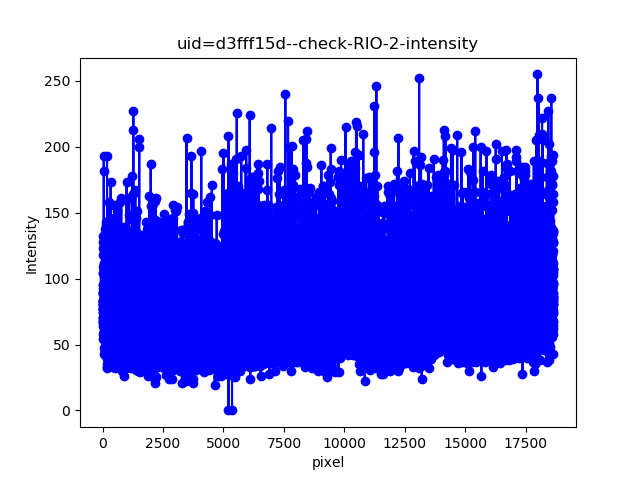

In [81]:
roi_mask_copy = roi_mask.copy()
qint =  2 #starting from 1
roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qint, uid =uidstr )

In [82]:
refine_roi = False

In [196]:
Nq = len( np.unique(roi_mask))-1

In [83]:
if refine_roi:
#if scat_geometry =='saxs':    
    roi_mask = roi_mask_copy
    filter_badpix_dict ={}
    for k in range(1, Nq +1 ):
        roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number=k, uid =uidstr, plot=False )    
        bad_pix_list=  get_bad_frame_list( roi_inten, fit=True, polyfit_order = 30, 
            scale= 3.5,  good_start = None, good_end= None, uid= uidstr, path=data_dir, plot=False)
        print( 'The bad frame list length is: %s'%len(bad_pix_list ) )
        filter_badpix_dict[k] = bad_pix_list

In [84]:
if refine_roi:
#if scat_geometry =='saxs':
    roi_mask = filter_roi_mask( filter_badpix_dict, roi_mask, avg_img, filter_type = 'badpix' )
    roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qint, uid =uidstr )

In [85]:
path

'/XF11ID/analysis/2018_2/masks/'

In [86]:
fp = path + 'uid=%s_roi_mask.pkl'%uid
cpk.dump( [roi_mask,qval_dict],  open(fp, 'wb' ) )
print(fp)
if scat_geometry == 'saxs':  
    if qphi_analysis:
        cpk.dump( [roi_mask_qr,qval_dict],  open( fp[:-4] +'_qr.pkl' , 'wb' ) )
        print('The Qr-ROI is also saved as %s due to doing phi-analysis.'%(fp[:-4] +'_qr.pkl'))

##save with a meaningful filename, make False after excute to avoid over-write
#if True:    
if False:
    #fp = path + 'roi_mask_April16_Coralpor_4M.pkl'
    fp = path + 'roi_mask_April16_Coralpor_4M_normal.pkl'
    #fp = path + 'roi_mask_April16_Coralpor_4M_wide.pkl'
    #fp = path + 'roi_mask_April16_Coralpor_4M_phi_4x_20deg.pkl'
    #fp = path + 'roi_mask_phi_4x_30deg_Coralpor.pkl'
    
    #fp = path + 'roi_mask_April16_Coralpor_500K_normal.pkl'
    #fp = path + 'roi_mask_April16_Coralpor_500K_wide.pkl'
    #fp = path + 'roi_mask_April16_Coralpor_500K_phi_4x_20deg.pkl'
    
    cpk.dump( [roi_mask,qval_dict],  open(fp, 'wb' ) )
    print(fp)



#roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data


/XF11ID/analysis/2018_2/masks/uid=d3fff15d_roi_mask.pkl


In [87]:
if scat_geometry == 'gi_saxs':    
    
    fp = path + 'uid=%s_roi_masks.pkl'%uid
    cpk.dump( [roi_masks,qval_dicts],  open(fp, 'wb' ) )
    print(fp)
    ##save with a meaningful filename, make False after excute to avoid over-write
    fp = path + 'uid=%s_qmap.pkl'%uid    #dump qr_map, qz_map, ticks_, Qrs, Qzs, Qr, Qz, inc_x0
    print(fp)
    cpk.dump( [qr_map, qz_map, ticks_, Qrs, Qzs, Qr, Qz, inc_x0, refl_x0, refl_y0 ],  open(fp, 'wb' ) )

        
